# LZTR1
[Noonan syndrome-10 (NS10)](https://omim.org/entry/616564) is caused by heterozygous mutation in the LZTR1 gene.
[Noonan syndrome 2 (NS2)](https://omim.org/entry/605275) caused by homozygous or compound heterozygous mutation in the LZTR1 gene

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'LZTR1'
mane_tx_id = 'NM_006767.4'
mane_protein_id = 'NP_006758.2' # leucine-zipper-like transcriptional regulator 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 38/38 [00:00<00:00, 180.01 individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #4
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)
     ·ontology_class of the time_of_death field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
27,Hypertrophic cardiomyopathy
26,Low-set ears
21,Posteriorly rotated ears
20,Hypertelorism
19,Downslanted palpebral fissures
18,Short neck
16,Short stature
16,Ptosis
16,Epicanthus
15,Low posterior hairline


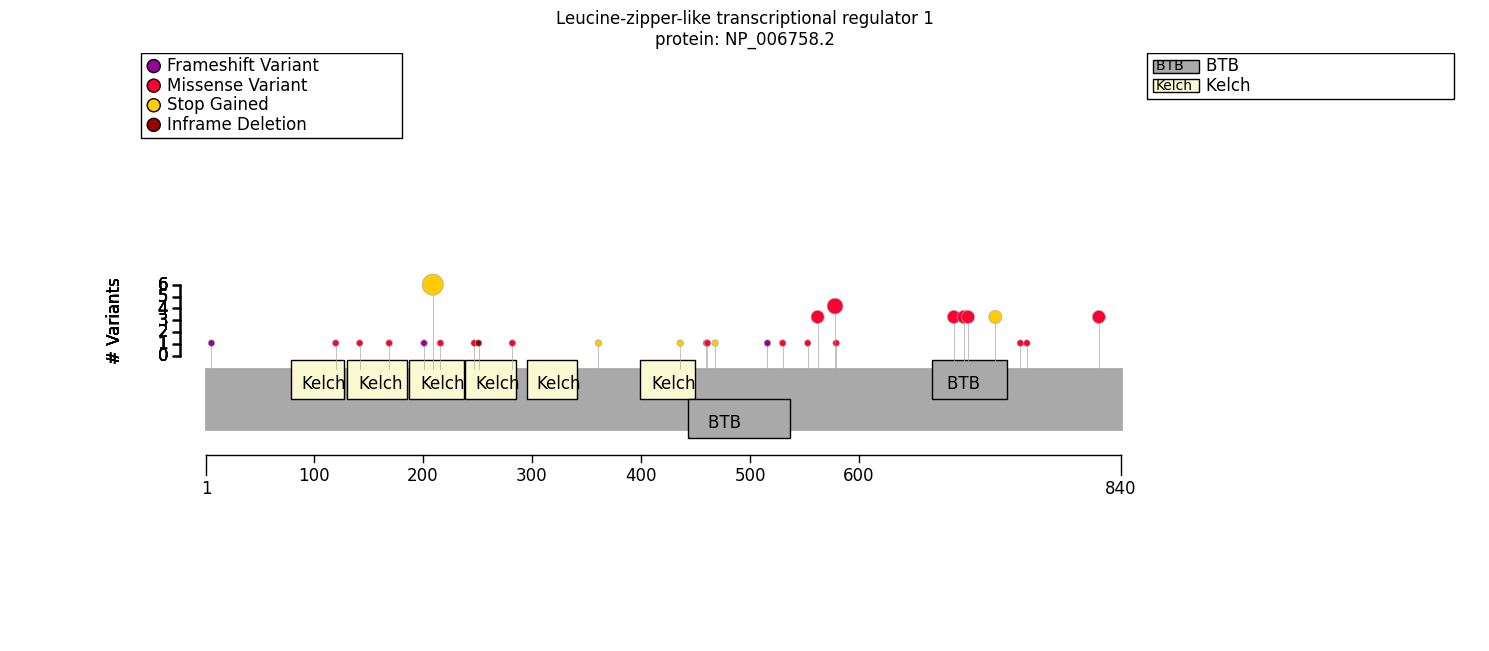

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

lztr1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
lztr1_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer


missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1),(2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,69
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,81
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,170


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense/Missense OR Missense/Other,Other/Other,Corrected p values,p values
Micrognathia [HP:0000347],3/13 (23%),6/7 (86%),0.219667,0.016641
Global developmental delay [HP:0001263],11/13 (85%),2/8 (25%),0.219667,0.017573
Cystic hygroma [HP:0000476],2/11 (18%),4/5 (80%),0.253497,0.035714
Atrial septal defect [HP:0001631],2/9 (22%),6/7 (86%),0.253497,0.040559
Hypertelorism [HP:0000316],12/16 (75%),3/8 (38%),0.497192,0.099438
Polyhydramnios [HP:0001561],1/10 (10%),5/10 (50%),0.585178,0.140867
Hypertrophic cardiomyopathy [HP:0001639],16/18 (89%),7/11 (64%),0.585178,0.163850
Low-set ears [HP:0000369],13/15 (87%),7/11 (64%),1.000000,0.347826
Ptosis [HP:0000508],9/19 (47%),3/11 (27%),1.000000,0.442484
Increased nuchal translucency [HP:0010880],5/13 (38%),2/3 (67%),1.000000,0.550000


In [9]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

n_term = protein_region(region=Region(0, 500), tx_id=mane_tx_id)
n_term_clf = biallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N Term",
    b_label="Other",
    partitions=((0,1),(2,))
)
n_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=n_term_result)


Allele group,N Term/N Term OR N Term/Other,Other/Other,Corrected p values,p values
Hypertrophic cardiomyopathy [HP:0001639],8/13 (62%),15/16 (94%),1.0,0.063820
Epicanthus [HP:0000286],7/13 (54%),4/16 (25%),1.0,0.142644
Short stature [HP:0004322],4/13 (31%),8/13 (62%),1.0,0.237744
Low posterior hairline [HP:0002162],9/13 (69%),6/14 (43%),1.0,0.251860
Polyhydramnios [HP:0001561],1/8 (12%),5/12 (42%),1.0,0.324561
Low-set ears [HP:0000369],8/12 (67%),12/14 (86%),1.0,0.365217
Midface retrusion [HP:0011800],5/12 (42%),6/9 (67%),1.0,0.386997
Global developmental delay [HP:0001263],7/13 (54%),6/8 (75%),1.0,0.399862
Posteriorly rotated ears [HP:0000358],12/12 (100%),9/10 (90%),1.0,0.454545
Cystic hygroma [HP:0000476],2/8 (25%),4/8 (50%),1.0,0.608392


In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Cystic hygroma [HP:0000476],2/10 (20%),4/6 (67%),1.0,0.118132
Downslanted palpebral fissures [HP:0000494],7/16 (44%),12/17 (71%),1.0,0.166320
Epicanthus [HP:0000286],10/18 (56%),6/17 (35%),1.0,0.314530
Short neck [HP:0000470],11/18 (61%),7/17 (41%),1.0,0.317539
Midface retrusion [HP:0011800],7/11 (64%),4/10 (40%),1.0,0.394856
Low posterior hairline [HP:0002162],9/14 (64%),6/13 (46%),1.0,0.449482
Increased nuchal translucency [HP:0010880],5/13 (38%),3/5 (60%),1.0,0.607843
Webbed neck [HP:0000465],7/9 (78%),5/9 (56%),1.0,0.619910
Atrial septal defect [HP:0001631],5/10 (50%),6/9 (67%),1.0,0.649917
Global developmental delay [HP:0001263],6/11 (55%),8/11 (73%),1.0,0.659443


# Summary

In [11]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
    GPAnalysisResultSummary.from_multi(result=n_term_result), 
    GPAnalysisResultSummary.from_multi(result=missense_result),
    GPAnalysisResultSummary.from_multi(result=mf_result), 
)

caption = "No significant association identified."
report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption
)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N Term/N Term OR N Term/Other,Other/Other,28,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Missense/Missense OR Missense/Other,Other/Other,25,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,31,0


In [13]:
summarizer.process_latex(report=report, protein_fig=lztr1_fig)

Figure saved to ../../supplement/img/LZTR1_protein_diagram-draft.pdf
Output to ../../supplement/tex/LZTR1_summary_draft.tex
